# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from  torch.cuda.amp import autocast, GradScaler
from fastai.vision.all import *
import timm
import torchvision.transforms.functional as K

%matplotlib inline

In [2]:
print(torch.__version__)

1.13.1+cu116


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
def gamma_correction(img, gamma):
    return K.adjust_gamma(img, gamma=gamma)

In [7]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                              transforms.RandomRotation(30),
                                              transforms.RandomVerticalFlip(p=0.5),
                                              transforms.RandomHorizontalFlip(p=0.5),
                                              # transforms.RandAugment(num_ops = 6, magnitude = 5),
                                              transforms.ColorJitter(brightness=0.1, saturation=0.1, hue=0.1),
                                              transforms.Lambda(lambda img: gamma_correction(img, gamma=0.5)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225]),
                                              transforms.RandomErasing()])
                                              

valid_transform = transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 16)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 16) 

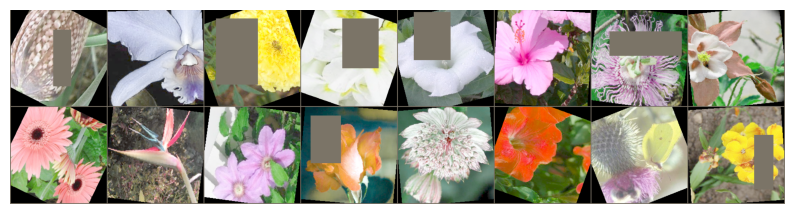

In [8]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.imshow(image)
    ax.axis('off') 
        
    # Make a grid from batch
images, _,  = next(iter(trainloader))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

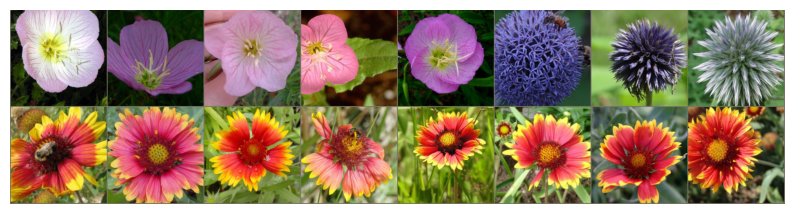

In [9]:
images, _,  = next(iter(testloader))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [12]:
import gc
gc.collect()

6390

In [13]:
torch.cuda.empty_cache()

In [14]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [15]:
# TODO: Build and train your network
model = timm.models.swin_large_patch4_window7_224(pretrained=True)
model

C:\Users\canku\anaconda3\envs\pytorchenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
           

In [16]:
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(
                           nn.Linear(in_features=1536, out_features=1536, bias=True),
                           nn.Mish(inplace=True),
                           nn.Dropout(0.6,inplace=False),
                           nn.BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                           nn.Linear(1536, 102, bias=True),
                           nn.LogSoftmax(dim = 1)
        )

model.head = classifier

In [17]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 1, min_lr = 7e-6, factor = 0.1)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.75)
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
           

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,40

In [19]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.33,0.33)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    #mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device)*data
    x2 = torch.from_numpy(1-mask).to(device)*shuffled_data
    targets=(targets, shuffled_targets, lam)
    
    return (x1+x2), targets

In [20]:
import math
import random

import numpy as np
from scipy.stats import beta


def fftfreqnd(h, w=None, z=None):
    """ Get bin values for discrete fourier transform of size (h, w, z)
    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    fz = fx = 0
    fy = np.fft.fftfreq(h)

    if w is not None:
        fy = np.expand_dims(fy, -1)

        if w % 2 == 1:
            fx = np.fft.fftfreq(w)[: w // 2 + 2]
        else:
            fx = np.fft.fftfreq(w)[: w // 2 + 1]

    if z is not None:
        fy = np.expand_dims(fy, -1)
        if z % 2 == 1:
            fz = np.fft.fftfreq(z)[:, None]
        else:
            fz = np.fft.fftfreq(z)[:, None]

    return np.sqrt(fx * fx + fy * fy + fz * fz)


def get_spectrum(freqs, decay_power, ch, h, w=0, z=0):
    """ Samples a fourier image with given size and frequencies decayed by decay power
    :param freqs: Bin values for the discrete fourier transform
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param ch: Number of channels for the resulting mask
    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    scale = np.ones(1) / (np.maximum(freqs, np.array([1. / max(w, h, z)])) ** decay_power)

    param_size = [ch] + list(freqs.shape) + [2]
    param = np.random.randn(*param_size)

    scale = np.expand_dims(scale, -1)[None, :]

    return scale * param


def make_low_freq_image(decay, shape, ch=1):
    """ Sample a low frequency image from fourier space
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param ch: Number of channels for desired mask
    """
    freqs = fftfreqnd(*shape)
    spectrum = get_spectrum(freqs, decay, ch, *shape)#.reshape((1, *shape[:-1], -1))
    spectrum = spectrum[:, 0] + 1j * spectrum[:, 1]
    mask = np.real(np.fft.irfftn(spectrum, shape))

    if len(shape) == 1:
        mask = mask[:1, :shape[0]]
    if len(shape) == 2:
        mask = mask[:1, :shape[0], :shape[1]]
    if len(shape) == 3:
        mask = mask[:1, :shape[0], :shape[1], :shape[2]]

    mask = mask
    mask = (mask - mask.min())
    mask = mask / mask.max()
    return mask


def sample_lam(alpha, reformulate=False):
    """ Sample a lambda from symmetric beta distribution with given alpha
    :param alpha: Alpha value for beta distribution
    :param reformulate: If True, uses the reformulation of [1].
    """
    if reformulate:
        lam = beta.rvs(alpha+1, alpha)
    else:
        lam = beta.rvs(alpha, alpha)

    return lam


def binarise_mask(mask, lam, in_shape, max_soft=0.0):
    """ Binarises a given low frequency image such that it has mean lambda.
    :param mask: Low frequency image, usually the result of `make_low_freq_image`
    :param lam: Mean value of final mask
    :param in_shape: Shape of inputs
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :return:
    """
    idx = mask.reshape(-1).argsort()[::-1]
    mask = mask.reshape(-1)
    num = math.ceil(lam * mask.size) if random.random() > 0.5 else math.floor(lam * mask.size)

    eff_soft = max_soft
    if max_soft > lam or max_soft > (1-lam):
        eff_soft = min(lam, 1-lam)

    soft = int(mask.size * eff_soft)
    num_low = num - soft
    num_high = num + soft

    mask[idx[:num_high]] = 1
    mask[idx[num_low:]] = 0
    mask[idx[num_low:num_high]] = np.linspace(1, 0, (num_high - num_low))

    mask = mask.reshape((1, *in_shape))
    return mask


def sample_mask(alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """ Samples a mean lambda from beta distribution parametrised by alpha, creates a low frequency image and binarises
    it based on this lambda
    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    """
    if isinstance(shape, int):
        shape = (shape,)

    # Choose lambda
    lam = sample_lam(alpha, reformulate)

    # Make mask, get mean / std
    mask = make_low_freq_image(decay_power, shape)
    mask = binarise_mask(mask, lam, shape, max_soft)

    return lam, mask


def sample_and_apply(x, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """
    :param x: Image batch on which to apply fmix of shape [b, c, shape*]
    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    :return: mixed input, permutation indices, lambda value of mix,
    """
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    index = np.random.permutation(x.shape[0])

    x1, x2 = x * mask, x[index] * (1-mask)
    return x1+x2, index, lam


class FMixBase:
    r""" FMix augmentation
        Args:
            decay_power (float): Decay power for frequency decay prop 1/f**d
            alpha (float): Alpha value for beta distribution from which to sample mean of mask
            size ([int] | [int, int] | [int, int, int]): Shape of desired mask, list up to 3 dims
            max_soft (float): Softening value between 0 and 0.5 which smooths hard edges in the mask.
            reformulate (bool): If True, uses the reformulation of [1].
    """

    def __init__(self, decay_power=3, alpha=1, size=(32, 32), max_soft=0.0, reformulate=False):
        super().__init__()
        self.decay_power = decay_power
        self.reformulate = reformulate
        self.size = size
        self.alpha = alpha
        self.max_soft = max_soft
        self.index = None
        self.lam = None

    def __call__(self, x):
        raise NotImplementedError

    def loss(self, *args, **kwargs):
        raise NotImplementedError

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
epochs = 10
print_every = 400
steps = 0

train_losses, validation_losses = [], []
for e in range(epochs):
    running_loss = 0
    for ii, (train_inputs, train_labels) in enumerate(trainloader):
        
        steps += 1
        optimizer.zero_grad()
        
        # Move input and label tensors to the GPU (if available)
        train_inputs= train_inputs.to(device)
        train_labels = train_labels.to(device).long()
#         mix_decision = np.random.rand()
#         if mix_decision < 0.25:
#             train_inputs, train_labels = cutmix(train_inputs, train_labels, 1.)
#         elif mix_decision >=0.25 and mix_decision < 0.5:
#             train_inputs, train_labels = fmix(train_inputs, train_labels, alpha=1., decay_power=5., shape=(224,224))
            
#         # Forward and backward passes
#         with autocast():
#             outputs = model.forward(train_inputs.float())  
            
#             if mix_decision < 0.50:
#                 loss = criterion(outputs, train_labels[0]) * train_labels[2] + criterion(outputs, train_labels[1]) * (1. - train_labels[2])
#             else:
#                 loss = criterion(outputs, train_labels)

        outputs = model.forward(train_inputs)
        loss = criterion(outputs, train_labels)
        
        loss.backward()
        # Forward and backward passes

        optimizer.step()
        
        
        running_loss += loss.item()

        if steps % print_every == 0:
            # Deactivate dropout
            model.eval()
            validation_loss = 0
            accuracy = 0
            
            for ii, (validation_inputs, validation_labels) in enumerate(validloader):
                optimizer.zero_grad()
                
                # We will keep using the training hardware for validation (cuda or cpu)
                validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
                model.to(device)
                
                with torch.no_grad():    
                    outputs = model.forward(validation_inputs)
                    validation_loss = criterion(outputs, validation_labels)
                    ps = torch.exp(outputs).data 
                    equality = (validation_labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            
            
                    
            validation_loss = validation_loss / len(validloader)
            train_loss = running_loss / len(trainloader)
            
            train_losses.append(train_loss)
            validation_losses.append(validation_loss.detach().cpu())
            
            accuracy = accuracy /len(validloader)
            
            current_lr = optimizer.param_groups[0]['lr']
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Training Loss: {:.5f}".format(running_loss/print_every),
                  "Validation Loss {:.7f}".format(validation_loss),
                  "LR: {:.8f}".format(current_lr),
                  "Accuracy: {:.4f}%".format(100 * accuracy))
            
            running_loss = 0
            scheduler.step(validation_loss)

C:\Users\canku\AppData\Local\Temp\ipykernel_25380\4013196267.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


Epoch: 1/10...  Training Loss: 1.78743 Validation Loss 0.0008604 LR: 0.00010000 Accuracy: 99.2788%
Epoch: 2/10...  Training Loss: 0.23769 Validation Loss 0.0001110 LR: 0.00010000 Accuracy: 99.6394%
Epoch: 3/10...  Training Loss: 0.14427 Validation Loss 0.0000442 LR: 0.00010000 Accuracy: 99.6394%
Epoch: 4/10...  Training Loss: 0.12008 Validation Loss 0.0000363 LR: 0.00010000 Accuracy: 99.6394%
Epoch: 5/10...  Training Loss: 0.11389 Validation Loss 0.0000011 LR: 0.00010000 Accuracy: 99.6394%
Epoch: 6/10...  Training Loss: 0.10347 Validation Loss 0.0000300 LR: 0.00010000 Accuracy: 99.7596%
Epoch: 7/10...  Training Loss: 0.07516 Validation Loss 0.0000044 LR: 0.00010000 Accuracy: 99.7596%
Epoch: 8/10...  Training Loss: 0.07323 Validation Loss 0.0000037 LR: 0.00001000 Accuracy: 99.7596%
Epoch: 9/10...  Training Loss: 0.06633 Validation Loss 0.0000036 LR: 0.00001000 Accuracy: 99.7596%
Epoch: 10/10...  Training Loss: 0.05279 Validation Loss 0.0000035 LR: 0.00000700 Accuracy: 99.7596%


<Figure size 2000x4000 with 0 Axes>

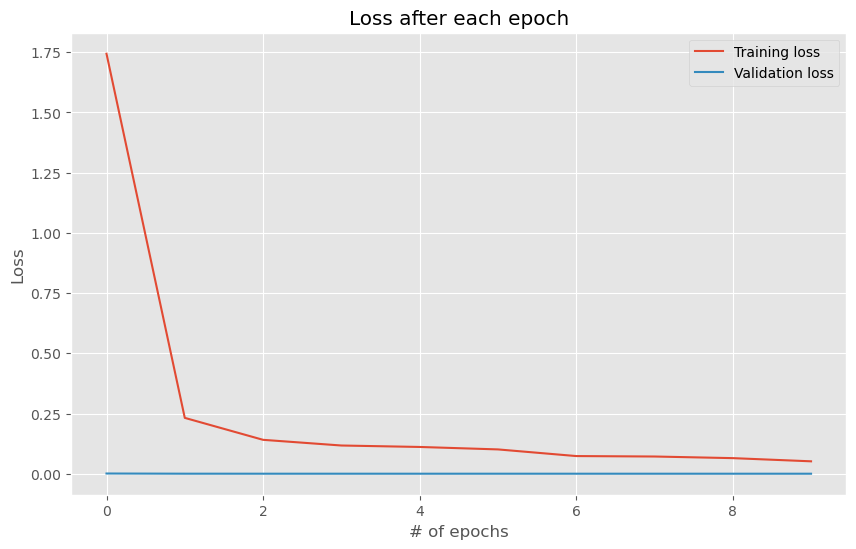

In [22]:
plt.style.use('ggplot')
plt.figure()
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, epochs), train_losses, label='Training loss')
plt.plot(np.arange(0, epochs), validation_losses, label='Validation loss')

plt.title('Loss after each epoch')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [23]:
accuracy = 0

for ii, (test_inputs, test_labels) in enumerate(testloader):
    # Move input and label tensors to the GPU (if available)
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

    # Get the class probabilities
    ps = torch.exp(model(test_inputs))
    
    # Make sure the shape is appropriate, we should get 102 class probabilities for 64 examples
    top_p, top_class = ps.topk(1, dim=1)
    
    # Look at the most likely classes for the first 10 examples
    equals = top_class == test_labels.view(*top_class.shape)
    
    accuracy += torch.mean(equals.type(torch.FloatTensor))
    
accuracy = accuracy /len(testloader)
print(f'Accuracy of the network on the test images: {accuracy.item()*100}%')

Accuracy of the network on the test images: 99.75961446762085%


In [25]:
model.class_to_idx = train_data.class_to_idx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of incorrect predictions: 2


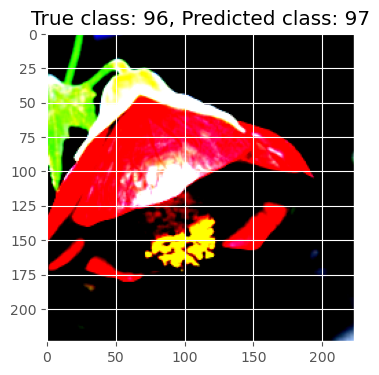

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


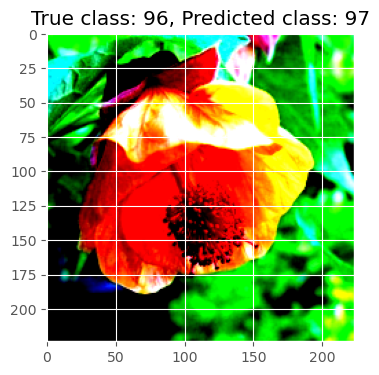

In [26]:
# Set model to evaluation mode
model.eval()

# Initialize list to store incorrect predictions
incorrect_predictions = []

# Loop through validation dataset
for inputs, labels in testloader:
    # Move input and label tensors to the GPU (if available)
    inputs, labels = inputs.to(device), labels.to(device)

    # Get model predictions
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # Find incorrect predictions
    for i in range(len(predicted)):
        if predicted[i] != labels[i]:
            incorrect_predictions.append((inputs[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

# Print number of incorrect predictions
print(f"Number of incorrect predictions: {len(incorrect_predictions)}")

class_names = list(testloader.dataset.class_to_idx.keys())
class_idx_to_name = {v: k for k, v in testloader.dataset.class_to_idx.items()}
# Set figure size
fig_size = (4, 4)

# Show some of the incorrect predictions
for i in range(min(10, len(incorrect_predictions))):
    inputs, label_idx, predicted_idx = incorrect_predictions[i]
    # Resize image
    inputs_resized = torch.nn.functional.interpolate(inputs.unsqueeze(0), size=(224, 224)).squeeze(0)
    # Convert input tensor to numpy array
    inputs_np = inputs_resized.permute(1, 2, 0).cpu().numpy()
    # Get class names
    true_class = class_idx_to_name[label_idx.item()]
    predicted_class = class_idx_to_name[predicted_idx.item()]
    # Create figure and axis
    fig, ax = plt.subplots(figsize=fig_size)
    # Show image
    ax.imshow(inputs_np)
    # Set title
    ax.set_title(f"True class: {true_class}, Predicted class: {predicted_class}")
    # Show figure
    plt.show()

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [27]:
checkpoint = {'input_size': 1536,
              'output_size': 102,
              'arch': 'swin_large_patch4_window7_224',
              'classifier' : classifier,
              'learning_rate': 0.0001,
              'epochs': epochs,
              'class_to_idx': model.class_to_idx,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
             }

torch.save(checkpoint, 'checkpoint_swin_large_patch4_window7_224SiLuFocalLossReducePlateauLRBest99759.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [28]:
import torchvision
from torchvision import datasets, transforms, models

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = getattr(timm.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    learning_rate = checkpoint['learning_rate']
    model.epochs = checkpoint['epochs']
    model.optimizer = checkpoint['optimizer']
    model.load_state_dict(checkpoint['state_dict'],strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

load_checkpoint('checkpoint_swin_large_patch4_window7_224SiLuFocalLossReducePlateauLRBest99759.pth')  
print(model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
           

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [29]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
   # TODO: Process a PIL image for use in a PyTorch model
    
    img = Image.open(image) 
    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    img = np.array(transform(img))

    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<AxesSubplot: >

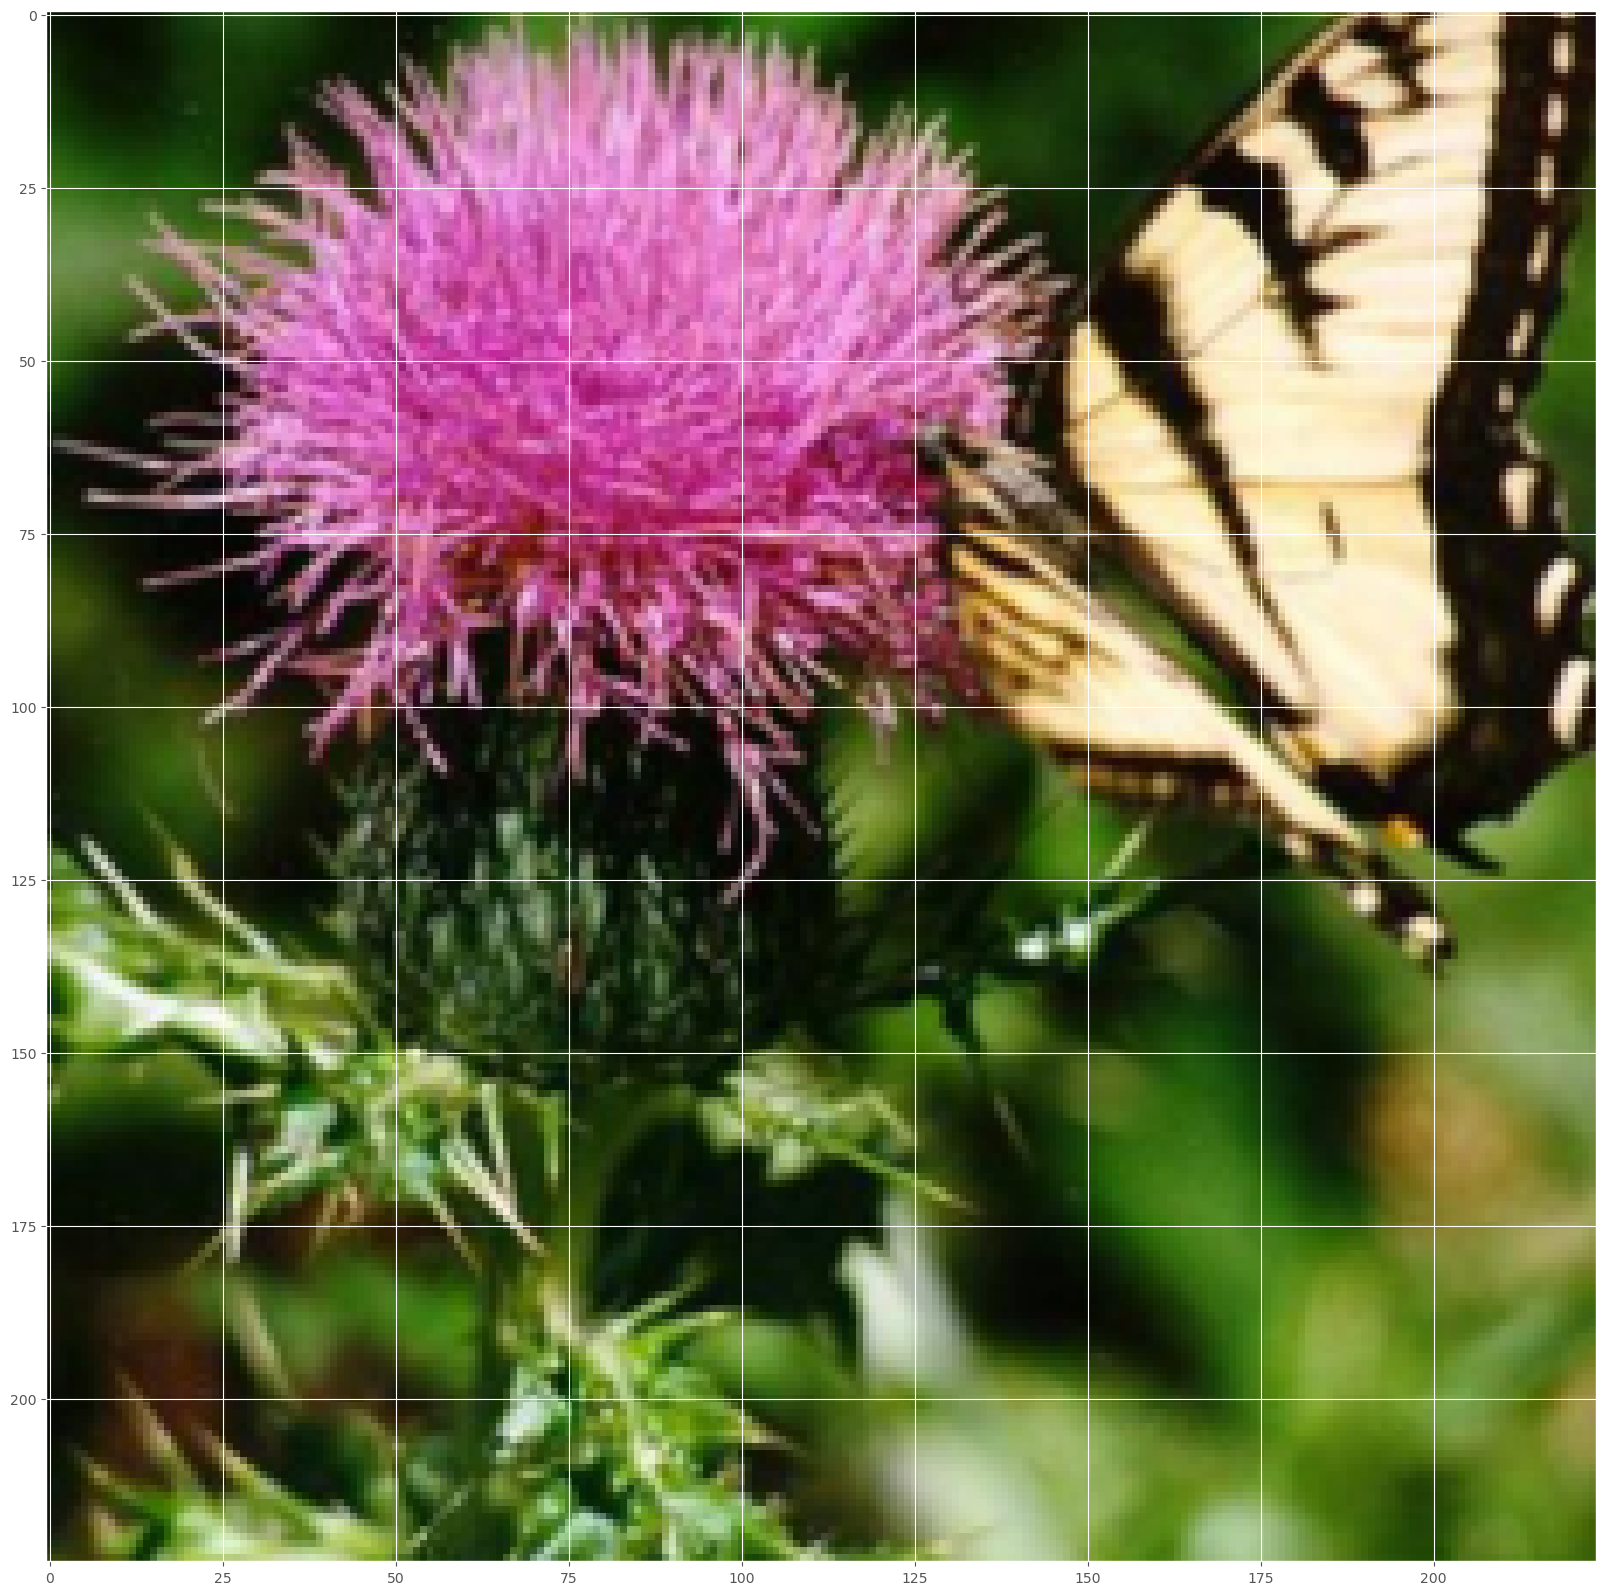

In [30]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
        
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


image = process_image('flowers/test/14/image_06083.jpg')
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [31]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.FloatTensor)
    image = image.unsqueeze(0) 
    image = image.to(device)
    
    # to make sure no drop; otherwise, the output is random
    model.eval()
    
    with torch.no_grad ():
        output = model.forward(image)
        
    output_prob = torch.exp(output)
    
    probs, indeces = output_prob.topk(topk)
    probs   =   probs.to('cpu').numpy().tolist()[0]
    indeces = indeces.to('cpu').numpy().tolist()[0]
    
    mapping = {val: key for key, val in model.class_to_idx.items()}
    classes = [mapping[item] for item in indeces]
    
    return probs, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

[0.9881781339645386, 0.0044095879420638084, 0.001762960571795702, 0.0014147445326671004, 0.0009038016432896256]
['14', '29', '92', '17', '10']
['spear thistle', 'artichoke', 'bee balm', 'purple coneflower', 'globe thistle']


<Figure size 300x300 with 0 Axes>

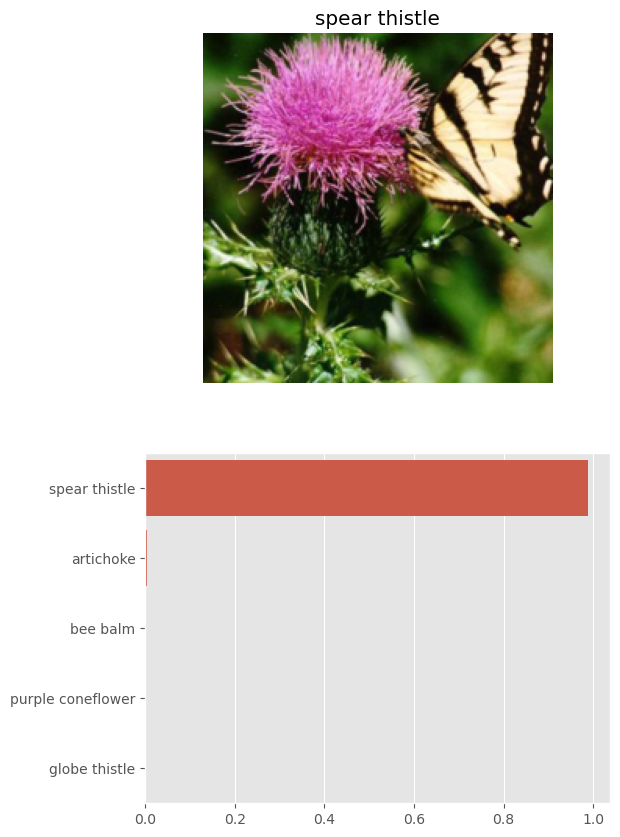

In [32]:
# TODO: Display an image along with the top 5 classes
plt.figure(figsize=(3,3))
    
path = ('flowers/test/14/image_06083.jpg') 
    
probs, classes = predict(path, model, 5)

names = [cat_to_name[key] for key in classes]

print(probs)
print(classes)
print(names)

plt.figure(figsize = (6,10))

ax    = plt.subplot(2,1,1)
image = process_image(path)
ax    = imshow(image, ax=ax, title=names[0])
ax.axis('off')

plt.subplot(2,1,2)
sns.barplot(x=probs, y=names, color=sns.color_palette()[0]);

plt.show()